## Fixed Angle analysis

In [26]:
degree = 3 # degree of graph
rounds = 2 # number of rounds

# Import modules and packages
import maxcut_benchmark
import time
import sys
sys.path[1:1] = [ "_common", "_common/qiskit", "maxcut/_common" ]
sys.path[1:1] = [ "../../_common", "../../_common/qiskit", "../../maxcut/_common/" ]
import common
import execute as ex
import metrics as metrics
import os
import numpy as np
import json
from qiskit import (Aer, execute)
import matplotlib.pyplot as plt
ex.set_noise_model(None)

# Load the fixed angles from angles_regular_graphs.json
with open(os.path.join('..','_common','angles_regular_graphs.json'), 'r') as json_file:
    fixed_angles_orig = json.load(json_file) #'thetas_array', 'approx_ratio_list', 'num_qubits_list'
deg_3_p_2 = fixed_angles_orig[str(degree)][str(rounds)]
thetas_list = deg_3_p_2['beta'] + deg_3_p_2['gamma'] # betas are first followed by gammas
for ind in range(rounds, rounds * 2):
    thetas_list[ind] *= 1


In [27]:
print(thetas_list)
print(deg_3_p_2)


[0.5550603400685824, 0.29250781484335187, 0.4877097327098487, 0.8979876956225422]
{'AR': 0.7559062918257108, 'gamma': [0.4877097327098487, 0.8979876956225422], 'beta': [0.5550603400685824, 0.29250781484335187]}


In [28]:
def ar_svs(num_qubits = 4, rounds = 2, degree = 3):
    """
    For a given problem (num nodes + degree), obtain the fixed angle approximation ratio using the state vector simulator
    """
    start = time.time()
    # Retrieve graph edges and optimal solution
    unique_id = i = 3 # degree
    instance_filename = os.path.join("..", "_common", common.INSTANCE_DIR, f"mc_{num_qubits:03d}_{i:03d}_000.txt")
    nodes, edges = common.read_maxcut_instance(instance_filename)
    opt, _ = common.read_maxcut_solution(instance_filename[:-4]+'.sol')

    ## Get the approximation ratio from the state vector simulator
    parameterized = False
    qc = maxcut_benchmark.MaxCut(num_qubits, i, edges, rounds, thetas_list, parameterized, measured = False)
    # qc2 = qc.decompose()
    backend_id='statevector_simulator'
    sv_backend = Aer.get_backend(backend_id)
    sv_result = execute(qc, sv_backend).result()
    # get the probability distribution
    cuts, counts, sizes = maxcut_benchmark.compute_cutsizes(sv_result, nodes, edges)
    sv_ar = np.sum([c * s for (c,s) in zip(counts, sizes)]) / opt
    
    end = time.time()
    # print("SVS for width={} took {} mins".format(num_qubits, (end-start)/60))
    return sv_ar

def ar_qasmSim(num_qubits = 4, rounds = 2, degree = 3, num_shots = 5000):
    """
    For a given problem (num nodes + degree), obtain the fixed angle approximation ratio using the qasm simulator
    """
    start = time.time()
    # Retrieve graph edges and optimal solution
    unique_id = i = 3 # degree
    instance_filename = os.path.join("..", "_common", common.INSTANCE_DIR, f"mc_{num_qubits:03d}_{i:03d}_000.txt")
    nodes, edges = common.read_maxcut_instance(instance_filename)
    opt, _ = common.read_maxcut_solution(instance_filename[:-4]+'.sol')

    ## Get the approximation ratio from qasm_simulator
    provider_backend=None
    hub="ibm-q"
    group="open"
    project="main"
    exec_options=None

    def execution_handler2 (qc, result, num_qubits, s_int, num_shots):
        # Stores the results to the global saved_result variable
        global saved_result
        saved_result = result
    
    ex.max_jobs_active = 1
    backend_id='qasm_simulator'
    ex.init_execution(execution_handler2)
    ex.set_execution_target(backend_id, provider_backend=provider_backend,
            hub=hub, group=group, project=project, exec_options=exec_options)
    # submit circuit for execution on target (simulator, cloud simulator, or hardware)
    qc = maxcut_benchmark.MaxCut(num_qubits, i, edges, rounds, thetas_list, parameterized = False, measured = True)
    qc2 = qc.decompose()
    ex.submit_circuit(qc2, num_qubits, unique_id, shots=num_shots)
    # Must wait for circuit to complete
    ex.finalize_execution(None, report_end=False)
    # ex.throttle_execution(metrics.finalize_group)
    # ex.finalize_execution(None, report_end=False)
    # print(saved_result)
    cuts, counts, sizes = maxcut_benchmark.compute_cutsizes(saved_result, nodes, edges)
    ar = - maxcut_benchmark.compute_sample_mean(counts, sizes) / opt
    end= time.time()
    # print("QASM Simulation for width={} took {} mins".format(num_qubits, (end-start)/60))
    return ar


In [29]:
degree = 3
num_shots = 1000
num_qubits_list = list(range(4,17,2))
svs_list = [0] * len(num_qubits_list)
qsm_list = [0] * len(num_qubits_list)

for ind, num_qubits in enumerate(num_qubits_list):
    svs_list[ind] = ar_svs(num_qubits = num_qubits, rounds = rounds, degree = degree)
    qsm_list[ind] = ar_qasmSim(num_qubits = num_qubits, rounds = rounds, degree = degree, num_shots = num_shots)
    print("Simulation for size {} done.".format(num_qubits))



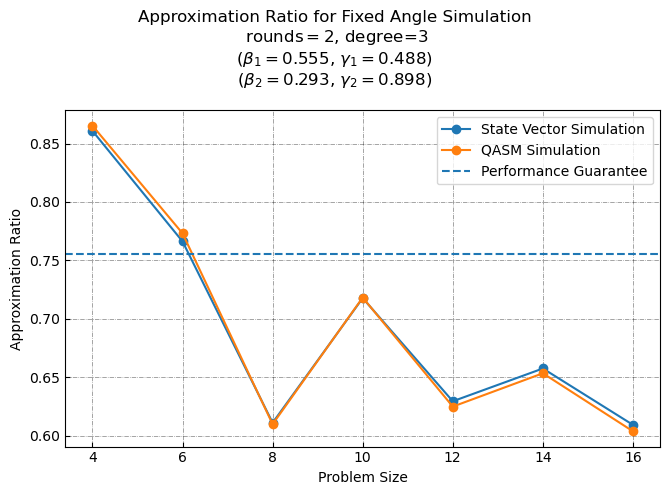

In [35]:
maxcut_style = os.path.join(os.path.join('..','..', '_common','maxcut.mplstyle'))
with plt.style.context(maxcut_style):
        fig, axs = plt.subplots(1, 1)
        suptitle = "Approximation Ratio for Fixed Angle Simulation\n rounds$={}$, degree=${}$ \n".format(rounds, degree)
        angle_str = ""
        for ind in range(rounds):
            angle_str += r"($\beta_{}={:.3f}$,".format(ind + 1, deg_3_p_2['beta'][ind])
            angle_str += r" $\gamma_{}={:.3f}$) ".format(ind + 1, deg_3_p_2['gamma'][ind]) + "\n"
        angle_str = angle_str[:-2]
        # and add the title to the plot
        plt.suptitle(suptitle + angle_str)
    
        axs.plot(num_qubits_list, svs_list, marker='o', ls = '-', label = f"State Vector Simulation")
        axs.plot(num_qubits_list, qsm_list, marker='o', ls = '-', label = f"QASM Simulation")
        axs.axhline(y = deg_3_p_2['AR'], ls = 'dashed', label = f"Performance Guarantee")

        axs.set_ylabel('Approximation Ratio')
        axs.set_xlabel('Problem Size')
        axs.grid()

        axs.legend()#loc='center left', bbox_to_anchor=(1, 0.5))

        fig.tight_layout()

        # save plot image to file
        # if save_plot_images:
        #     save_plot_image(plt, f"{appname}-ECDF-" + suffix, backend_id)
            
        # show the plot for user to see
            # plt.show()